In [1]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import numpy as np
import nbodykit
from nbodykit.lab import BigFileCatalog, HaloCatalog, cosmology, FFTPower, SimulationBox2PCF
import matplotlib.pyplot as plt


# Implement HOD

## `Nbodykit` interface:

### Default Zheng+07:

In [2]:
cosmo = cosmology.Planck15
from nbodykit.hod import Zheng07Model


def load_hlo_cat():
    pig_file = '/home/qezlou/HD1/simulations/Goku/PIG_016'
    cat = BigFileCatalog(pig_file, dataset='FOFGroups')
    redshift = 1/cat.attrs['Time'] - 1
    cat['Mass'] *= 1e10
    halos = HaloCatalog(cat, 
                        cosmo=cosmo, 
                        redshift=redshift,
                        mdef='vir',
                        mass='Mass',
                        position='MassCenterPosition',
                        velocity='MassCenterVelocity')
    return halos

def populate_halos(seed=42):
    halos = load_hlo_cat()
    hod = halos.populate(Zheng07Model, alpha=0.5, sigma_logM=0.40, seed=seed)
    print("total number of HOD galaxies = ", hod.csize)
    print(hod.columns)

    print("number of centrals = ", hod.compute((hod['gal_type']==0).sum()))
    print("number of satellites = ", hod.compute((hod['gal_type']==1).sum()))


    cen_idx = hod['gal_type'] == 0
    sat_idx = hod['gal_type'] == 1

    cens = hod[cen_idx]
    sats = hod[sat_idx]

    return hod, cens, sats


def plot_power(fig, ax, seed=42):
    """Plot the power spectrum of the galaxies, centrals, and satellites."""
    hod, cens, sats = populate_halos(seed=seed)
    gal_power = FFTPower(hod, mode='1d', Nmesh=512)
    cen_power = FFTPower(cens, mode='1d', Nmesh=512)
    sat_power = FFTPower(sats, mode='1d', Nmesh=512)
    cen_sat_power = FFTPower(cens, second=sats, mode='1d', Nmesh=512)
    # z-space pwoer
    LOS = [0, 0, 1]
    hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
    mesh = hod.to_mesh(position='RSDPosition', Nmesh=512, compensated=True)
    rsd_gal_power = FFTPower(mesh, mode='1d').run()[0]


    # plot galaxy auto power, centrals auto power, and sats auto power
    labels = [r"$P^{gg}$", r"$P^{cc}$", r"$P^{ss}$"]
    for i, r in enumerate([gal_power, cen_power, sat_power]):
        Pk = r.power
        ax.loglog(Pk['k'], Pk['power'].real-Pk.attrs['shotnoise'], label=labels[i])

    ax.loglog(rsd_gal_power['k'], rsd_gal_power['power']-rsd_gal_power.attrs['shotnoise'], label=r'$P^{gg}_{zspace}$', ls='--')
    ax.legend()
    ax.set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    ax.set_ylabel(r"$P(k)$ [$h^{-3} \ \mathrm{Mpc}^3$]")


def plot_corr(fig, ax, seed=42):
    """Plot the power spectrum of the galaxies, centrals, and satellites."""
    hod, cens, sats = populate_halos(seed=seed)
    r_edges = np.arange(60,200,5)
    corr_gal_real = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges, position='Position', nthreads=12)
    corr_gal_real.run()

    # z-space pwoer
    LOS = [0, 0, 1]
    hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS
    corr_gal_zspace = SimulationBox2PCF(data1=hod, mode='1d', edges=r_edges,  position='RSDPosition', nthreads=12)
    corr_gal_zspace.run()
    
    ax.plot(corr_gal_real.corr['r'], corr_gal_real.corr['corr'], label=r'$\xi^{gg}_{zspace}$', ls='--')
    ax.plot(corr_gal_zspace.corr['r'], corr_gal_zspace.corr['corr'], label=r'$\xi^{gg}_{zspace}$', ls='--')
    print(corr_gal_real.corr['r'], corr_gal_real.corr['corr'])
    ax.set_xlabel(r"$r$ [$h^{-1} \ \mathrm{Mpc}$]")
    ax.set_ylabel(r"$\xi(r)$")



In [3]:
halos = load_hlo_cat()

In [11]:
halos['Position']/=1000

halos['Position'][:].compute()

array([[696.93135835, 614.27385867, 641.06263952],
       [442.66369888, 657.50090213, 654.99298447],
       [989.31183609, 266.70874978, 188.48426805],
       ...,
       [999.6791766 , 947.59195531, 472.20765365],
       [997.91132179, 969.81433498, 503.80974401],
       [998.37543005, 111.24835956, 350.93375164]])

In [3]:
halos = load_hlo_cat()
halos['Position'] /= 1000
r_edges = np.arange(60,200,5)
corr = SimulationBox2PCF(data1=halos, mode='1d', edges=r_edges, position='Position', nthreads=12)
corr.run()
corr.corr['r']
fig, ax = plt.subplots()

ax.plot(corr.corr['r'], corr.corr['corr'], label=r'$\xi^{gg}_{zspace}$', ls='--')
ax.set_xscale('log')

: 

total number of HOD galaxies =  289236
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  244921
number of satellites =  44315
total number of HOD galaxies =  288518
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  244916
number of satellites =  43602


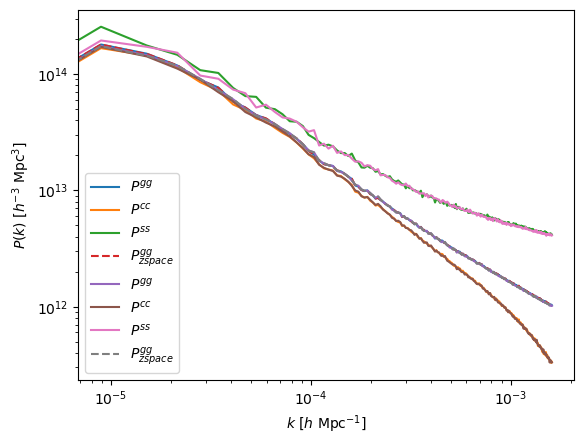

In [13]:
fig, ax= plt.subplots(1,1)
plot_power(fig, ax, seed=42)
plot_power(fig, ax, seed=20)

total number of HOD galaxies =  289236
['Position', 'Selection', 'Value', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_hostid', 'halo_id', 'halo_mvir', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']
number of centrals =  244921
number of satellites =  44315
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.] [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1.]


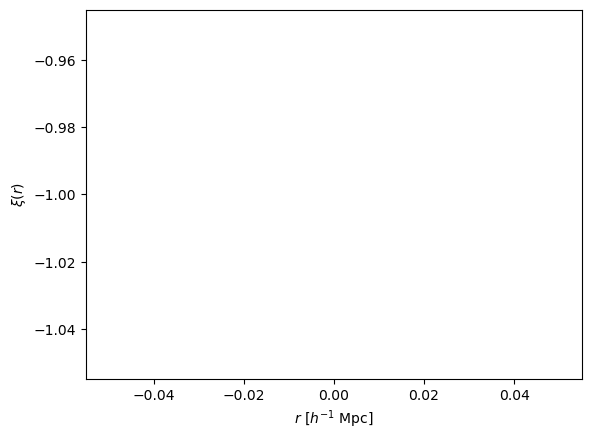

In [34]:
fig, ax= plt.subplots(1,1)
plot_corr(fig, ax, seed=42)

## Costum HOD model:

In [9]:
nbodykit.hod

<module 'nbodykit.hod' from '/home/qezlou/miniconda3/envs/het-cosmo/lib/python3.8/site-packages/nbodykit/hod.py'>

In [40]:
diff = (hod['RSDPosition'] / hod['Position'] - 1).compute()
print(np.min(diff), np.max(diff))
del diff


-0.2706028626358894 0.23365135970888828
